# Forecasting Methods

In this notebook we will see some of the methods used in Time Series Analysis to make forecasts, starting from the naïve baseline and then looking at some more complex techniques.

Let's import the libraries we need.

In [1]:
import warnings

from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

%matplotlib inline

We import the classic Airline Passengers dataset:

In [2]:
# import data
data_set = pd.read_csv('data/airline_passengers.csv',infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])

### Focus on the residuals

We want to train our model only on the residuals, so we have to remove all the non-stationary components present in the dataset.

In this case we already know that there is a clear increasing trend and also seasonality with a period of 12. We also already know how to obtain the residual without trend and seasonality.

First we remove the trend:

In [3]:
detrended_data_set = data_set.diff()

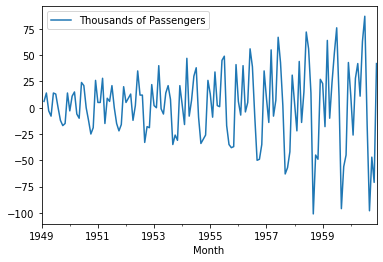

In [4]:
detrended_data_set.plot()
plt.show()

And then we remove the seasonality:

In [5]:
residuals = detrended_data_set.diff(12)

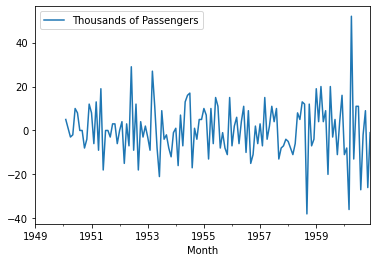

In [6]:
residuals.plot()
plt.show()

### Train-Test Split

Since we are starting to create the models to forecast, we need to split our original dataset into train and test data, in this way we are able to evaluate the performance of each technique. Indeed, the objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

- Train Dataset: Used to fit the machine learning model.
- Test Dataset: Used to evaluate the fit machine learning model.


In [7]:
train = residuals[:'1957-01-01'].copy().rename(columns={"Thousands of Passengers": "train"})
test = residuals['1957-01-02':].copy().rename(columns={"Thousands of Passengers": "test"})

Let's plot both the train and the test part:

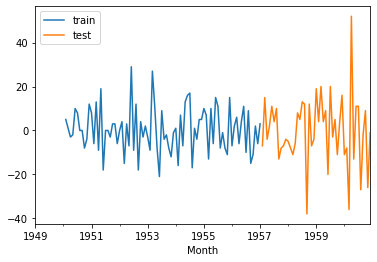

In [8]:
ax = train.plot()
test.plot(ax=ax)
plt.show()

## Baseline forecasting methods

The first step before deep dive into data analysis and modeling the time series with advanced TSA techniques is to establish a baseline of performance.

This will provide both a template for evaluating models and a performance measure by which all more elaborate predictive models can be compared.

### Naïve Forecast

In [9]:
def naive(data):
    return data[-1]

In [10]:
naive_pred = naive(train["train"])
naive_pred

3.0

### Simple mean

In [11]:
def simple_mean(data):
    return data.mean()

In [12]:
sm_pred = simple_mean(train["train"])
sm_pred

0.3333333333333333

After the "training" phase, we can make the predictions:

In [13]:
test["naive_pred"] = naive_pred
test["sm_pred"] = sm_pred

And we can plot the results:

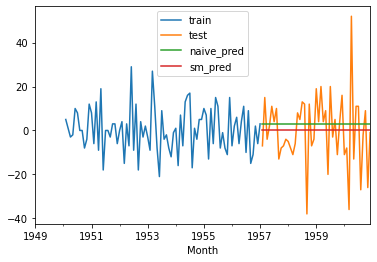

In [14]:
ax = train.plot()
bx = test.plot(ax=ax)
plt.show()

#### Which is the best one?

In [15]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(y_true, y_pred):
    print("MAE:",mae(y_true, y_pred))
    print("MSE:", mse(y_true, y_pred))
    print("RMSE:", np.sqrt(mse(y_true, y_pred)))
    print("MAPE:", mape(y_true, y_pred))

In [16]:
naive_predictions = np.repeat(naive_pred, repeats=len(test['test']))
evaluate(test['test'], naive_predictions)

MAE: 11.936170212765957
MSE: 250.31914893617022
RMSE: 15.821477457436465
MAPE: 109.75639624155862


In [17]:
sm_predictions = np.repeat(sm_pred, repeats=len(test['test']))
evaluate(test['test'], sm_predictions)

MAE: 11.836879432624118
MSE: 240.9763593380615
RMSE: 15.523413263134545
MAPE: 100.8476374074545


#### Please recall that MAPE is susceptible to division by zero, i.e., when actual values are close to zero. For this reason, for this time series MAPE is not the optimal metric and should not be considered when comparing these results.

In this case the Simple Mean seems to outperform the Naïve Forecast, since all the errors are lower.

## More sophisticated forecasting methods


### Last k mean

We can also used other techniques to make the baseline predictions, like the *Last K Mean*.

In [18]:
def lastk_mean(data, k):
    return data[-k:].mean()

In [19]:
last12_pred = lastk_mean(train["train"], k=12)
last12_pred

-0.9166666666666666

#### Find the best k    

Try to change **k**, in order to find the value that obtains the best performance:

In [20]:
last24_pred = lastk_mean(train["train"], k=24)
last24_pred

-0.2916666666666667

In [21]:
last36_pred = lastk_mean(train["train"], k=36)
last36_pred

0.6388888888888888

In [22]:
test["last12_pred"] = last12_pred
test["last24_pred"] = last24_pred
test["last36_pred"] = last36_pred

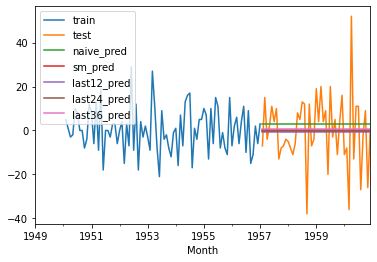

In [23]:
ax = train.plot()
bx = test.plot(ax=ax)
plt.show()

In [24]:
last12_predictions = np.repeat(last12_pred, repeats=len(test['test']))
evaluate(test['test'], last12_predictions)

MAE: 11.810283687943265
MSE: 241.49276004728137
RMSE: 15.54003732451378
MAPE: 97.66899712950014


In [25]:
last24_predictions = np.repeat(last24_pred, repeats=len(test['test']))
evaluate(test['test'], last24_predictions)

MAE: 11.82358156028369
MSE: 240.8439346926714
RMSE: 15.519147357141481
MAPE: 99.2583172684773


In [26]:
last36_predictions = np.repeat(last36_pred, repeats=len(test['test']))
evaluate(test['test'], last36_predictions)

MAE: 11.84338061465721
MSE: 241.32543669556082
RMSE: 15.534652770357013
MAPE: 101.62463836428779


#### Which k obtains the best performance?

The last 12 and the last 24 obtains overall the best performance, with the former having a lower MAE and MAPE and the latter having a lower MSE and RMSE.

#### Comparing with the prvious 2 approaches
Last 24 obtains better performance compared to the Simple Mean method.

### Simple Exponential Smoothing

We can import the model directly from the **statsmodels** library.

In [27]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

Before training the SES we need to remove the nan vales coming from the differecing part.

In [28]:
train = train[13:]

In [29]:
warnings.filterwarnings("ignore") # suppress warnings

train.index = pd.DatetimeIndex(train.index.values, freq=None)
fit02 = SimpleExpSmoothing(train, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
SES02_predictions = fit02.forecast(len(test))

In [30]:
evaluate(test['test'], SES02_predictions)

MAE: 11.826145739720173
MSE: 243.8419085306629
RMSE: 15.615438147252318
MAPE: 98.87641585947557


We can change the alpha parameter of the Simple Exponential Smoothing and find the best one(s).

In [31]:
warnings.filterwarnings("ignore") # suppress warnings

for i in np.linspace(0,1,11):
    print('Simple Exponential Smoothing with alpha = ', round(i, 2))
    fit = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=i, optimized=False)
    SES_alpha_predictions = fit.forecast(len(test))
    evaluate(test['test'], SES_alpha_predictions)
    print()

Simple Exponential Smoothing with alpha =  0.0
MAE: 12.202836879432624
MSE: 265.32132387706855
RMSE: 16.288686990579336
MAPE: 122.1627401913889

Simple Exponential Smoothing with alpha =  0.1
MAE: 11.809064561638905
MSE: 241.68661306949787
RMSE: 15.546273285565833
MAPE: 97.50166925943726

Simple Exponential Smoothing with alpha =  0.2
MAE: 11.826145739720173
MSE: 243.8419085306629
RMSE: 15.615438147252318
MAPE: 98.87641585947557

Simple Exponential Smoothing with alpha =  0.3
MAE: 11.826843136493025
MSE: 243.9572945197001
RMSE: 15.619132322882091
MAPE: 98.93254453150232

Simple Exponential Smoothing with alpha =  0.4
MAE: 11.818010368580712
MSE: 242.65462560652645
RMSE: 15.577375440250725
MAPE: 98.22165576267115

Simple Exponential Smoothing with alpha =  0.5
MAE: 11.812855085925275
MSE: 241.30636853982244
RMSE: 15.53403902852772
MAPE: 97.97632257928016

Simple Exponential Smoothing with alpha =  0.6
MAE: 11.828548022645418
MSE: 240.80198918667574
RMSE: 15.517795886873746
MAPE: 99.8518

Considering the MAE, the best results are obtained by Simple Exponential Smoothing with alpha = 0.1, while for the MSE the best alpha is 0.6.

## Directly forecasting a time series with trend and seasonality

We can rely also on more sophisticated models, that take into account already the trend and even the seasonality. In this case, we just have to input the dataset to the model, without the need to differencing or detrending it.

In [32]:
# import data
data_set = pd.read_csv('data/airline_passengers.csv',infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])

In [33]:
train = data_set[:'1957-01-01'].copy().rename(columns={"Thousands of Passengers": "train"})
test = data_set['1957-01-02':].copy().rename(columns={"Thousands of Passengers": "test"})

### Holt
The Holt models can handle the linear trend, so we can set a smoothing_trend.

In [34]:
fitHolt = Holt(train['train']).fit(smoothing_level = 0.2,smoothing_trend = 0.05)
test['Holt'] = fitHolt.forecast(len(test))

In [35]:
evaluate(test['test'], test['Holt'])

MAE: 51.69007385588371
MSE: 4774.377208871444
RMSE: 69.09686830002822
MAPE: 11.635357567368738


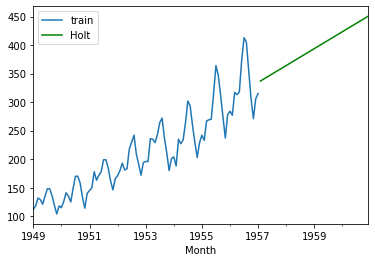

In [36]:
ax = train.plot()
test[['Holt']].plot(ax=ax,color='green')
plt.show()

Access the parameters of the fitted model:

In [40]:
fitHolt.params

{'smoothing_level': 0.2,
 'smoothing_trend': 0.05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 116.70431064779726,
 'initial_trend': 1.6302499265528578,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt-Winters

But we know that the Airline Passengers does not have only a trend, but also clear seasonalities. In this case it would be better to rely on the Holt-Winters models that can handle automatically also the seasonality.

In [37]:
fitTES = ExponentialSmoothing(train['train'],
                              seasonal_periods=12,
                              trend='add', 
                              seasonal='add',
                              use_boxcox=True,
                              initialization_method="estimated").fit()

test['Holt-Winters'] = fitTES.forecast(len(test))

In [38]:
evaluate(test['test'], test['Holt-Winters'])

MAE: 37.72878685835209
MSE: 2004.9248687831064
RMSE: 44.77638740210186
MAPE: 9.27639976383433


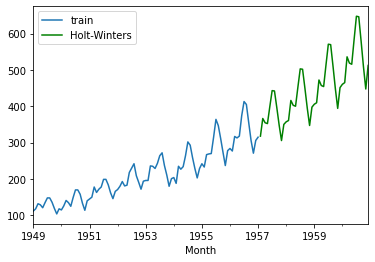

In [39]:
ax = train.plot()
test[['Holt-Winters']].plot(ax=ax, color='green')
plt.show()

Access the parameters of the fitted model:

In [41]:
fitTES.params

{'smoothing_level': 0.6423726708275829,
 'smoothing_trend': 1.8404357328000764e-18,
 'smoothing_seasonal': 0.0,
 'damping_trend': nan,
 'initial_level': 4.917521282576508,
 'initial_trend': 0.011192693799619995,
 'initial_seasons': array([-0.09208815, -0.09252288,  0.04681563,  0.00112374, -0.01685606,
         0.10225338,  0.20298432,  0.18950307,  0.06217099, -0.08588545,
        -0.234119  , -0.10187964]),
 'use_boxcox': True,
 'lamda': 0.009493520204101014,
 'remove_bias': False}